## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
# ! pip install mpld3
# import mpld3
# mpld3.enable_notebook()

In [2]:
# ! pip install numba
# ! pip install pyts
# from pyts.decomposition import SingularSpectrumAnalysis
# https://arxiv.org/pdf/1409.5181.pdf

In [3]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

from matplotlib import pyplot as plt

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Set parameters
    fs = 125
    pass_band = (40/60, 240/60)
    cutoff_freq = 12
    verbose = True
    window_size = 8*fs # Ground truth BPM provided in 8 second windows
    window_shift = 2*fs # Successive ground truth windows overlap by 2 seconds
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
        
    # Load ground truth pulse rate 
    # It was measurec each 8 second
    ground_truth = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1) 
    
    # Compute pulse rate estimates and estimation confidence.
    #########################################
    # ------------ Pre Process ------------ #
    #########################################
    # Bandpass filter
    ppg_filtered = BandpassFilter(ppg, pass_band, fs)
    accx_filtered = BandpassFilter(accx, pass_band, fs)
    accy_filtered = BandpassFilter(accy, pass_band, fs)
    accz_filtered = BandpassFilter(accz, pass_band, fs)
    
    # Lowpass filter
    # accx_filtered = LowpassFilter(accx, cutoff_freq, fs)
    # accy_filtered = LowpassFilter(accy, cutoff_freq, fs)
    # accz_filtered = LowpassFilter(accz, cutoff_freq, fs)
    
    # The accelerometer channels are aggregated into a magnitude signal.
    acc_filtered = np.sqrt(accx_filtered ** 2 + accy_filtered ** 2 + accz_filtered ** 2)
    
    # The accelerometer channels are aggregated into a magnitude signal.
    # acc_filtered = BandpassFilter(np.sqrt(accx ** 2 + accy ** 2 + accz ** 2), pass_band, fs)
    # acc_filtered = LowpassFilter(np.sqrt(accx ** 2 + accy ** 2 + accz ** 2), cutoff_freq, fs)
    
    ##########################################
    # ------------ Main Process ------------ #
    ##########################################
    # Estimate pulse rate with confidence
    estimated_pulse_rates = []
    confidences = []
    estimated_pulse_rate_previous = 1
    
    for i in range(len(ground_truth)):
        estimated_pulse_rate, confidence = EstimatePulseRate(ppg_filtered[window_shift*i : window_shift*i+window_size], 
                                                             acc_filtered[window_shift*i : window_shift*i+window_size], 
                                                             fs, pass_band, estimated_pulse_rate_previous, verbose=(i==0))
        estimated_pulse_rates.append(estimated_pulse_rate)
        confidences.append(confidence)
        
        estimated_pulse_rate_previous = estimated_pulse_rate
        
        if((i==0)):
            print("ground truth:{}, estimated:{}".format(ground_truth[i], estimated_pulse_rate))
    
    ################################################
    # ------------ Evaluation Process ------------ #
    ################################################
    # errors = np.abs(np.subtract(estimated_pulse_rates, ground_truth))
    errors = np.abs(np.subtract(np.convolve(np.array(estimated_pulse_rates), np.ones(5)/5.0, mode='same'), ground_truth))
    mae = np.mean(errors)
    print("MAE:{}".format(mae))
    
    if verbose:
        plt.figure()
        plt.scatter(x=ground_truth, y=estimated_pulse_rates, c=confidences)
        plt.colorbar()
        plt.plot([40,260], [40,260], 'k:')
        plt.xlim([40,260])
        plt.ylim([40,260])
        plt.xlabel('Pulse rate (Ground Truth)[bpm]')
        plt.ylabel('Pulse rate (Estimated)[bpm]')

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.array(errors), np.array(confidences)
    return errors, confidence

def EstimatePulseRate(ppg, acc, fs, pass_band, estimated_pulse_rate_previous, verbose=False):
    """
    Estimate Pulse rate with confidence using ppg and accelerometer data.

    Args:
        ppg: (np.array) a PPG signal
        acc: (np.array) an accelerometer signal
        fs: (number) a sampling rate of ppg/acc
        pass_band: (tuple) a bass band of band-pass filter for ppg/acc
        estimated_pulse_rate_previous: (number) previous estimated value of pulse rate
        verbose: (bool) Displays intermediate calculation results and diagrams
        
    Returns:
        estimated_pulse_rate: (number) estimated value of pulse rate
        confidence: (number) confidence value of the estimated pulse rate
        
    """ 
       
    # Do FFT
    freqs_ppg, fft_mag_ppg = DoFFT(ppg, fs)
    freqs_acc, fft_mag_acc = DoFFT(acc, fs)
    
    # Apply filter
    fft_mag_ppg[freqs_ppg <= pass_band[0]] = 0.0
    fft_mag_ppg[freqs_ppg >= pass_band[1]] = 0.0
    fft_mag_acc[freqs_acc <= pass_band[0]] = 0.0
    fft_mag_acc[freqs_acc >= pass_band[1]] = 0.0
    
    # Calculate maximum frequency of ppg and acc
    maximum_freq_ppg = freqs_ppg[np.argmax(fft_mag_ppg, axis=0)]  
    maximum_freq_acc = freqs_acc[np.argmax(fft_mag_acc, axis=0)]
    
    # Exclude the peak frequency band of acc from the frequency band of ppg
    fft_mag_ppg_new = fft_mag_ppg.copy()
    fft_mag_th = np.percentile(fft_mag_acc[(freqs_acc >= (40/60)) & (freqs_acc <= (240/60))], 95) # 95 percentile
    # fft_mag_ppg_new[fft_mag_acc>fft_mag_th] = 0.0
    fft_mag_ppg_new[np.convolve(fft_mag_acc>fft_mag_th, np.ones(3), 'same').astype(np.bool)] = 0.0
    
    # Inverse FFT
    ppg_new = DoInverseFFT(fft_mag_ppg_new)
    pks_ppg_new = DetectPeaks(ppg_new, height=1, distance=None)
    
    # Detect peaks of ppg
    pks_ppg = DetectPeaks(ppg, height=1, distance=None)
    pks_fft_mag_ppg = DetectPeaks(fft_mag_ppg, height=2000)
    pks_fft_mag_ppg_new = DetectPeaks(fft_mag_ppg_new, height=2000)

    # If the maximum frequency of ppg and the maximum frequency of acc are the same, 
    # calculate the pulse rate by excluding the maximum frequency of acc from ppg
    if(maximum_freq_ppg == maximum_freq_acc):
        # freq_pulse_rate = freqs_ppg[np.argsort(fft_mag_ppg, axis=0)[-2]]
        # freq_pulse_rate = freqs_ppg[np.argmax(fft_mag_ppg_new, axis=0)]
        
        # Extract 5 maximum values, excluding the maximum value of acc
        est_range = np.argsort(fft_mag_ppg[fft_mag_ppg!=maximum_freq_acc], axis=0)[-5:]
        # Select the closest value from the previous estimate
        freq_pulse_rate = freqs_ppg[est_range[np.argmin(np.abs(freqs_ppg[est_range] - (estimated_pulse_rate_previous/60)))]]
        
        # Estimate pulse rate with confidence
        estimated_pulse_rate = freq_pulse_rate * 60
        confidence = CalculateConfidence(freq_pulse_rate, freqs_ppg, fft_mag_ppg)
    else:
        # freq_pulse_rate = freqs_ppg[np.argmax(fft_mag_ppg, axis=0)]
        # freq_pulse_rate = freqs_ppg[np.argmax(fft_mag_ppg_new, axis=0)]
        
        # Extract 5 maximum values
        est_range = np.argsort(fft_mag_ppg, axis=0)[-5:]
        # Select the closest value from the previous estimate
        freq_pulse_rate = freqs_ppg[est_range[np.argmin(np.abs(freqs_ppg[est_range] - (estimated_pulse_rate_previous/60)))]]
        
        # Estimate pulse rate with confidence
        estimated_pulse_rate = freq_pulse_rate * 60
        confidence = CalculateConfidence(freq_pulse_rate, freqs_ppg, fft_mag_ppg)
    
    # Visualize signals
    if verbose:
        ts = np.arange(0,len(ppg)/fs,1/fs)
        
        plt.figure(figsize=(20,10))
        plt.subplot(3,2,1)
        plt.plot(ts, ppg)
        plt.plot(ts[pks_ppg], ppg[pks_ppg], 'or')
        plt.xlabel('Time []')
        plt.ylabel('PPG []')
        plt.grid()
        plt.subplot(3,2,2)
        plt.plot(ts, acc)
        plt.xlabel('Time []')
        plt.ylabel('ACC []')
        plt.grid()
        plt.subplot(3,2,3)
        plt.specgram(ppg, Fs=fs, noverlap=0)
        plt.xlabel('Time []')
        plt.ylabel('Frequency [Hz]')
        plt.ylim([0,10])
        plt.grid()
        plt.subplot(3,2,4)
        plt.specgram(acc, Fs=fs, noverlap=0)
        plt.xlabel('Time []')
        plt.ylabel('Frequency [Hz]')
        plt.ylim([0,10])
        plt.grid()
        plt.subplot(3,2,5)
        plt.plot(freqs_ppg, fft_mag_ppg)
        plt.plot(freqs_ppg[pks_fft_mag_ppg], fft_mag_ppg[pks_fft_mag_ppg], 'or')
        plt.xlabel('Frequency [Hz]')
        plt.xlim([0,10])
        plt.grid()
        plt.subplot(3,2,6)
        plt.plot(freqs_acc, fft_mag_acc)
        plt.axhline(fft_mag_th, color='k', ls=':')
        plt.xlabel('Frequency [Hz]')
        plt.xlim([0,10])
        plt.grid()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(20,10))
        plt.subplot(3,1,1)
        plt.plot(ts, ppg_new)
        plt.plot(ts[pks_ppg_new], ppg_new[pks_ppg_new], 'or')
        plt.xlabel('Time []')
        plt.ylabel('PPG []')
        plt.grid()
        plt.subplot(3,1,2)
        plt.specgram(ppg_new, Fs=fs, noverlap=0)
        plt.xlabel('Time []')
        plt.ylabel('Frequency [Hz]')
        plt.ylim([0,10])
        plt.grid()
        plt.subplot(3,1,3)
        plt.plot(freqs_ppg, fft_mag_ppg)
        plt.plot(freqs_acc, fft_mag_acc)
        plt.plot(freqs_ppg, fft_mag_ppg_new)
        plt.axvline(estimated_pulse_rate/60, color='k', ls=':')
        plt.plot(freqs_ppg[pks_fft_mag_ppg_new], fft_mag_ppg_new[pks_fft_mag_ppg_new], 'or')
        plt.xlabel('Frequency [Hz]')
        plt.xlim([0,10])
        plt.legend(['PPG','ACC','PPG(Filtered)'])
        plt.grid()
        plt.tight_layout()
        plt.show()
    
    return estimated_pulse_rate, confidence

def BandpassFilter(signal, pass_band, fs):
    """
    Applies bandpass filter.
    
    Args:
        signal: (np.array) an input signal
        pass_band: (tuple) a pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) a sampling rate of <signal>
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def LowpassFilter(signal, cutoff_freq, fs):
    """
    Applies lowpass filter.
    
    Args:
        signal: (np.array) an input signal
        cutoff_freq: (number) a frequency to want to cut off
        fs: (number) a sampling rate of <signal>
        
    Returns:
        (np.array) a filtered signal
    """
    b, a = sp.signal.butter(3, cutoff_freq, btype='lowpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)
    
def DetectPeaks(signal, height=10, distance=35):
    """
    Detects peaks of the signal.
    
    Args:
        signal: (np.array) an input signal
        height: (number) a threshold of height of peak 
        distance: (number) a threshold of distance between peaks
    
    Returns: 
        signal: (np.array) am index of input signal's peaks
    
    """
    pks = sp.signal.find_peaks(signal, height, distance)[0]
    return pks
    
def DoFFT(signal_time_domain, fs):
    """
    Applies Fast Fourier Transform.
    
    Args:
        signal_time_domain: (np.array) an input time-domain signal
        fs: (number) a sampling rate of <signal>
    
    Returns: 
        freqs: (np.array) a FFT frequency of the input signal
        fft_mag: (np.array) a FFT amplitude spectrum of the input signal
    
    """
    freqs = np.fft.rfftfreq(len(signal_time_domain), 1/fs)
    fft_mag = np.abs(np.fft.rfft(signal_time_domain))
    return freqs, fft_mag

def DoInverseFFT(signal_freq_domain):
    """
    Applies Inverse Fast Fourier Transform.
    
    Args:
        signal_freq_domain: (np.array) an input frequency-domain signal
    
    Returns: 
        (np.array) a time-domain signal
    
    """
    
    return np.fft.irfft(signal_freq_domain)

def CalculateConfidence(freq_estimated_pulse_rate, freqs_ppg, fft_mag_ppg):
    """
    Calculates a confidence value for the chosen frequency by computing the ratio of energy concentrated near that frequency compared to the full signal.
    
    Args:
        freq_estimated_pulse_rate: (number) a pulse rate estimated by the algorithm
        freqs_ppg: (np.array) a FFT frequency of ppg
        fft_mag_ppg: (np.array) a FFT amplitude spectrum of ppg
    
    Returns:
        confidence: (number) a confidence of pulse rate estimated by the algorithm
    
    """
    window = (freqs_ppg >= freq_estimated_pulse_rate - (40/60.0)) & (freqs_ppg <= freq_estimated_pulse_rate + (40/60.0))
    confidence = np.sum(fft_mag_ppg[window])/np.sum(fft_mag_ppg)
    
    return confidence

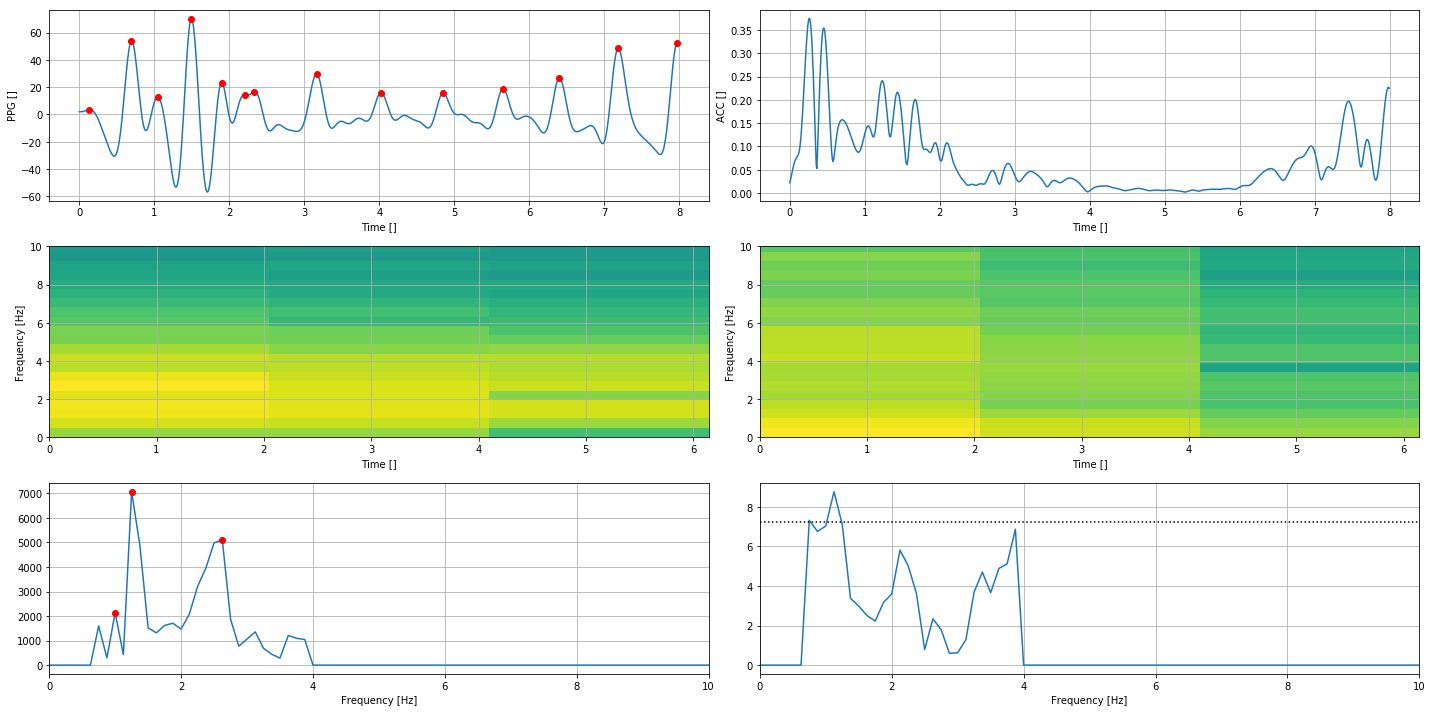

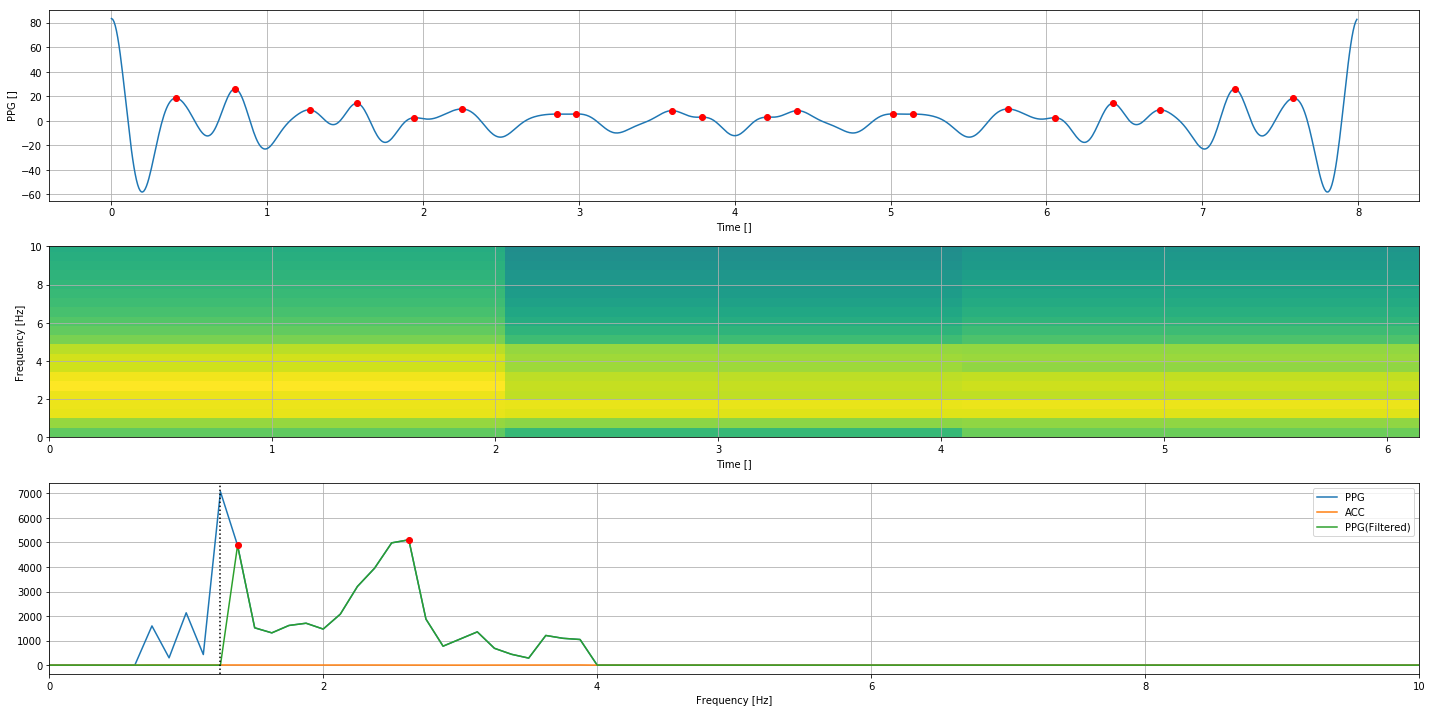

ground truth:74.33920704845815, estimated:75.0
MAE:18.480445974653332


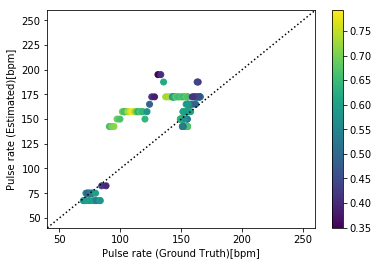

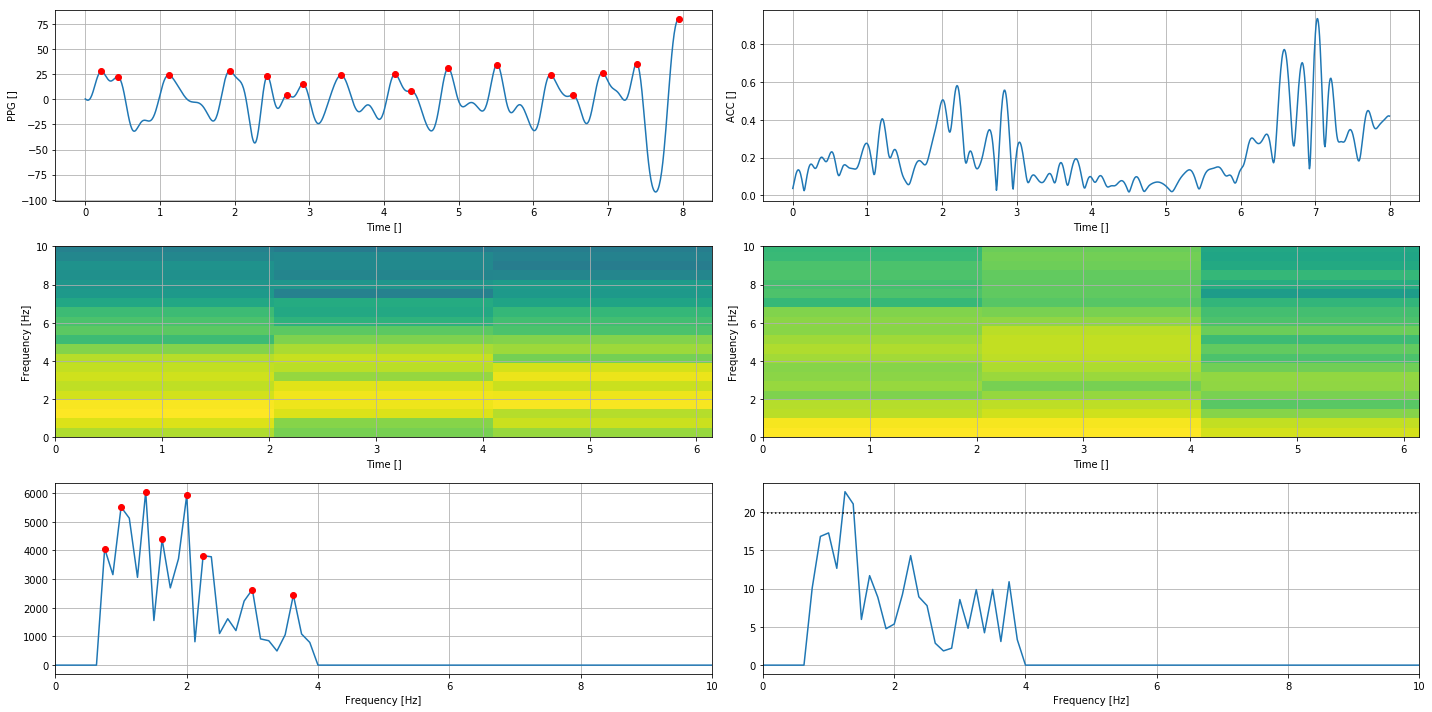

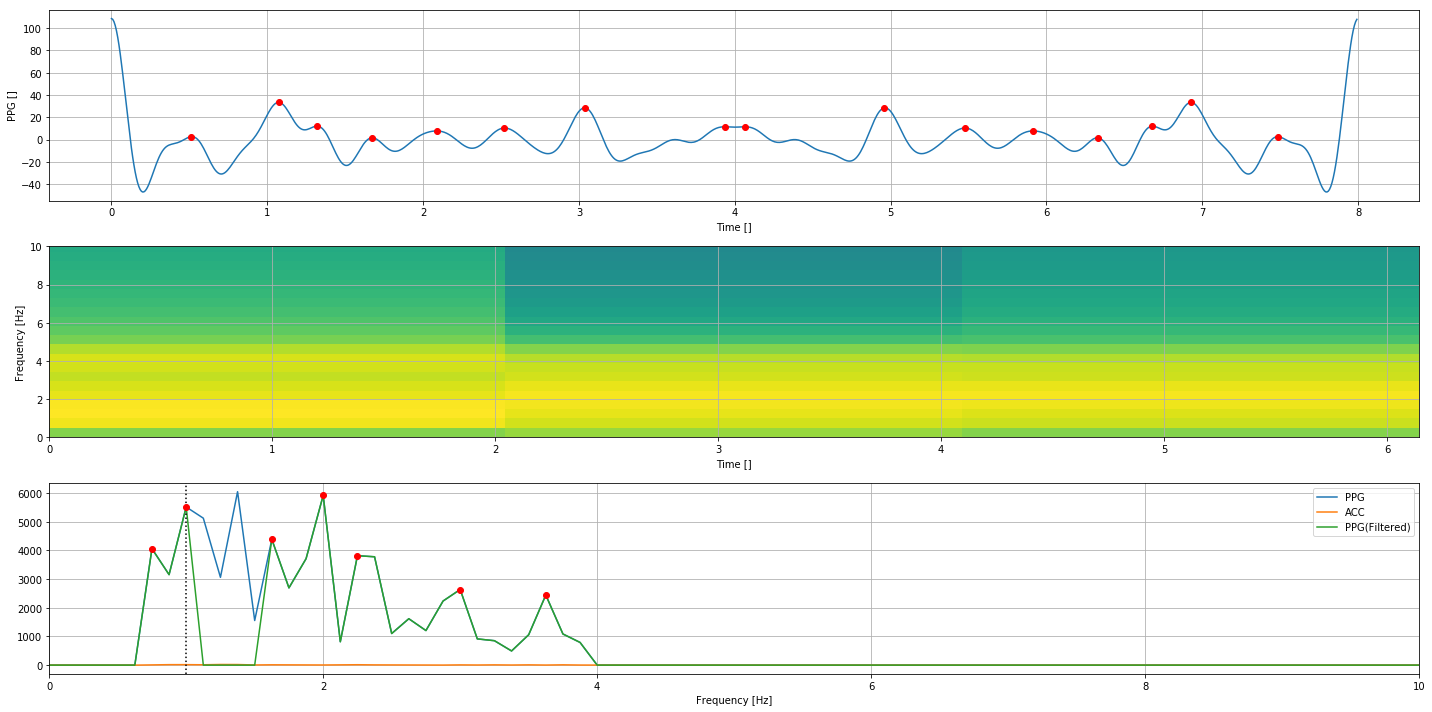

ground truth:84.74576271186442, estimated:60.0
MAE:19.351522291343347


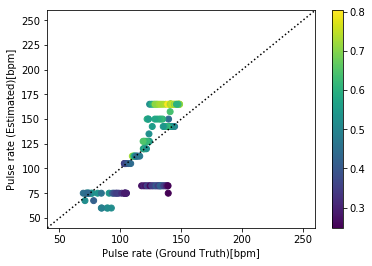

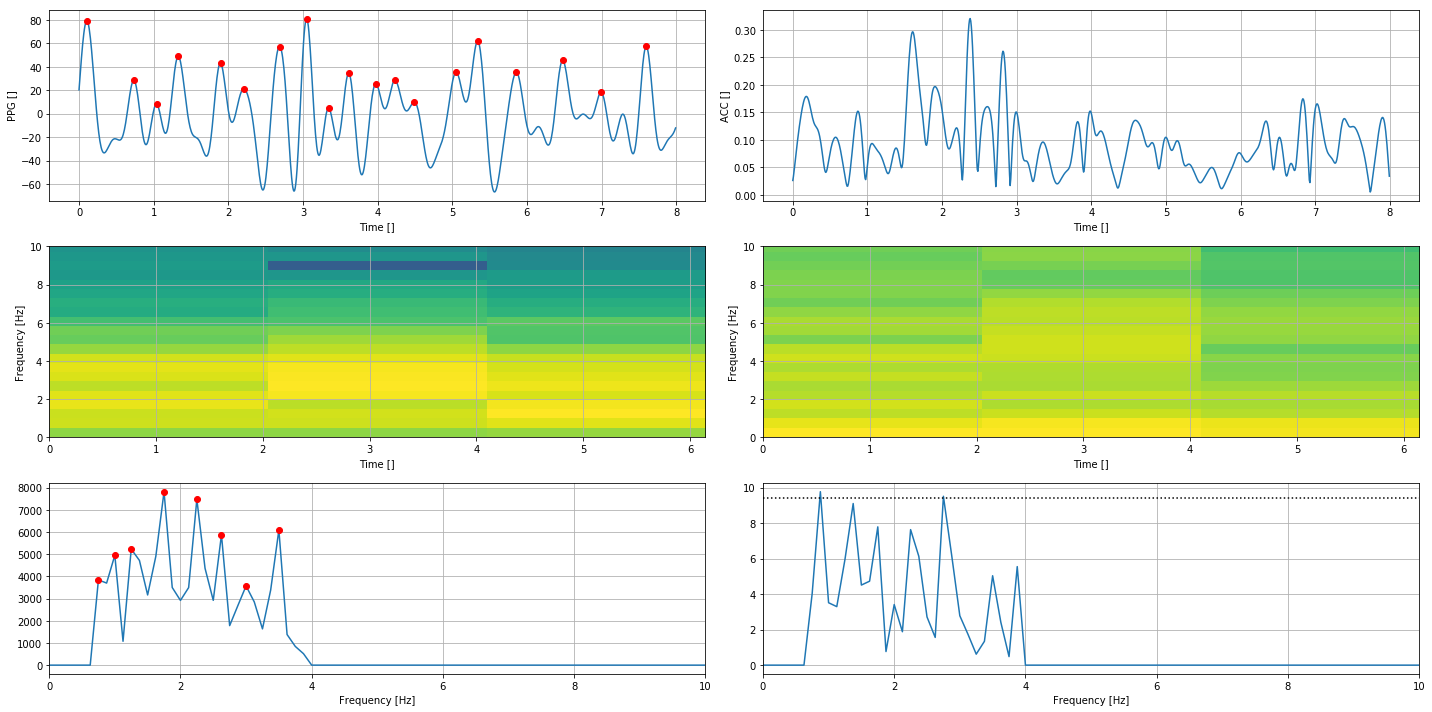

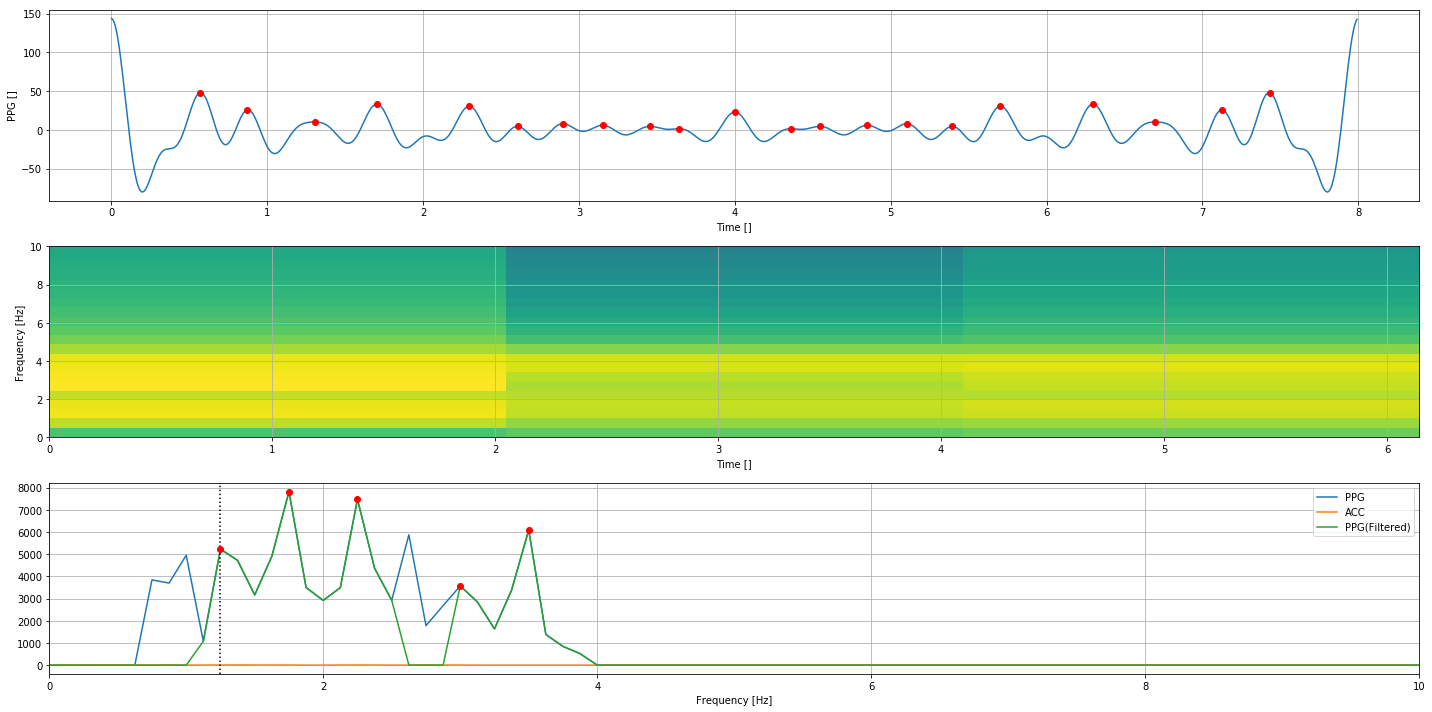

ground truth:104.0555, estimated:75.0
MAE:7.880258571428572


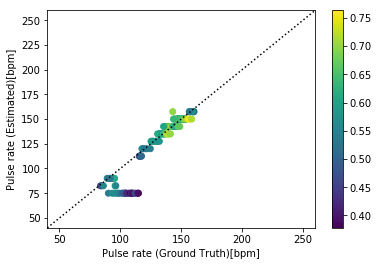

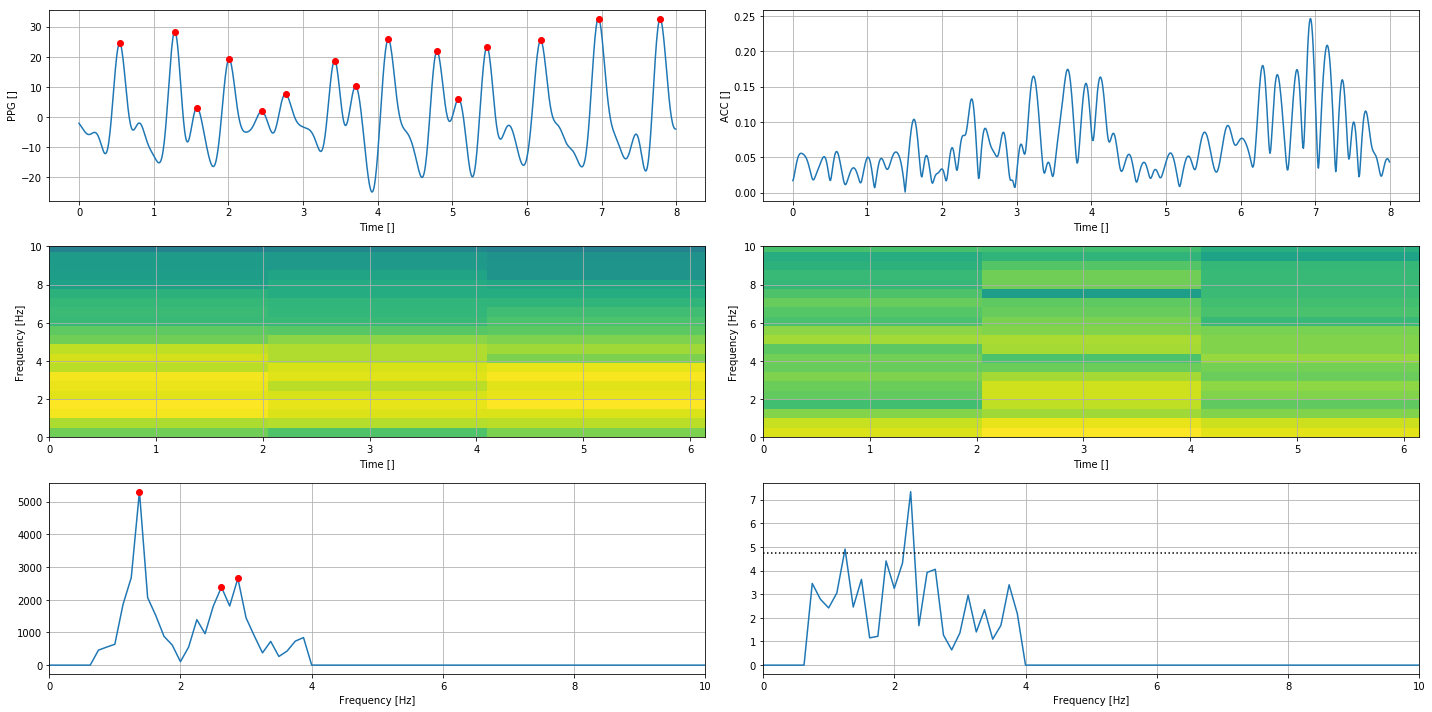

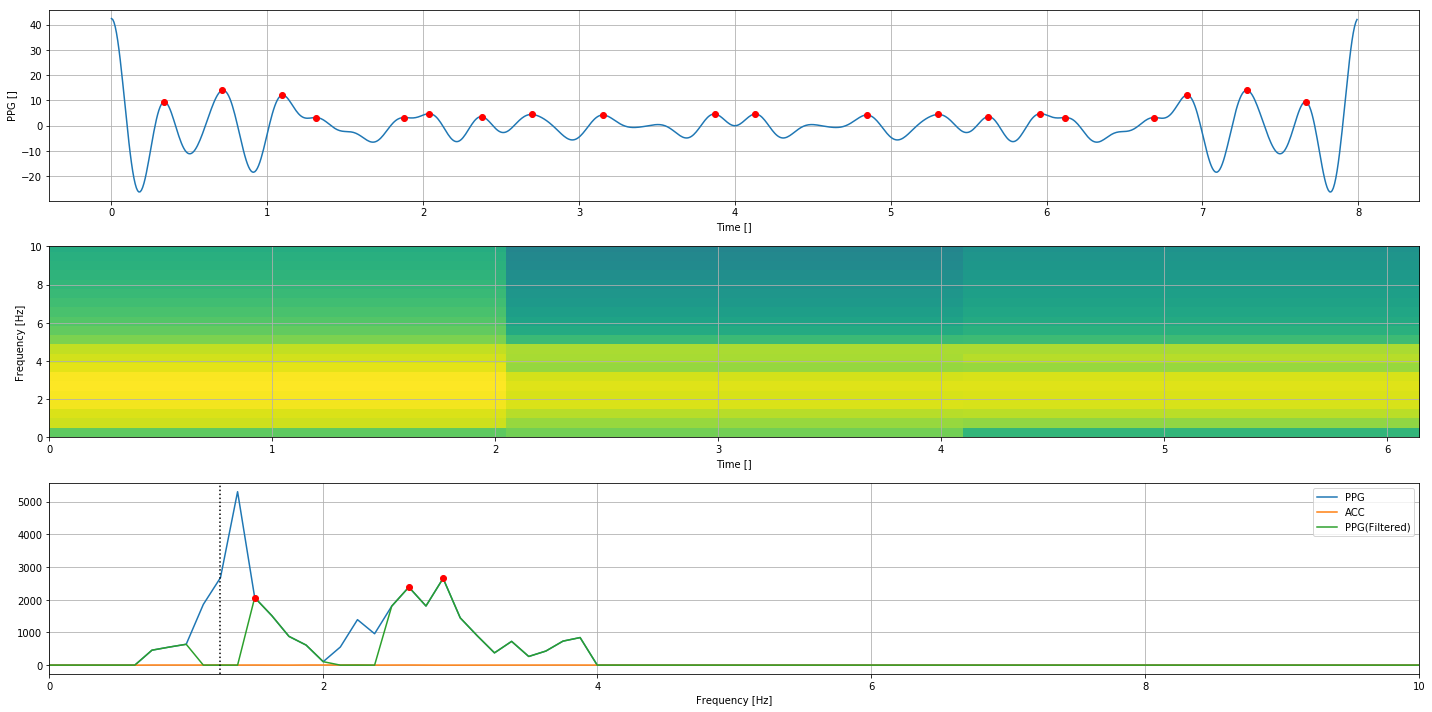

ground truth:82.873, estimated:75.0
MAE:7.562654205607476


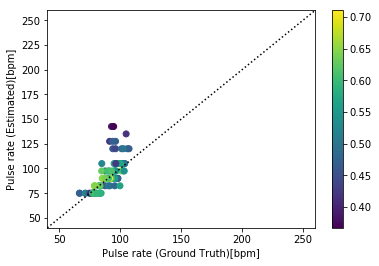

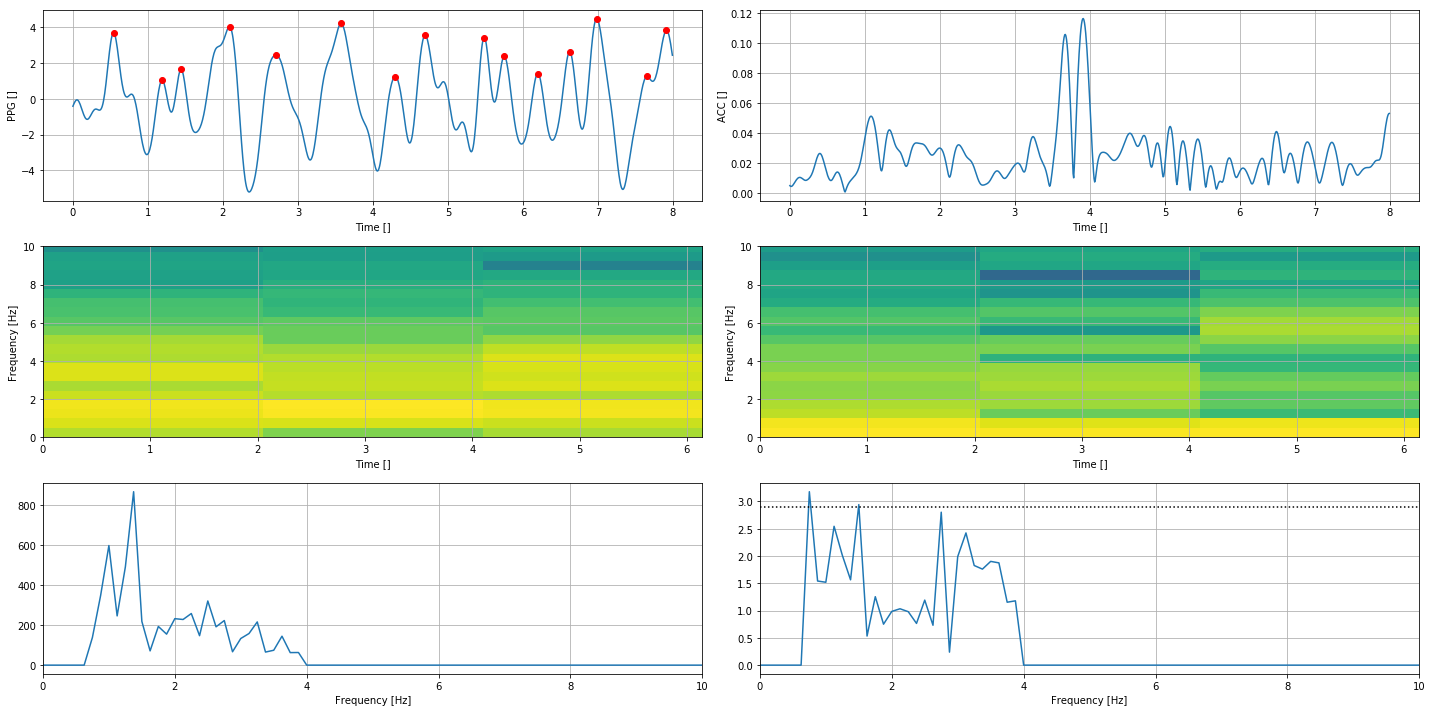

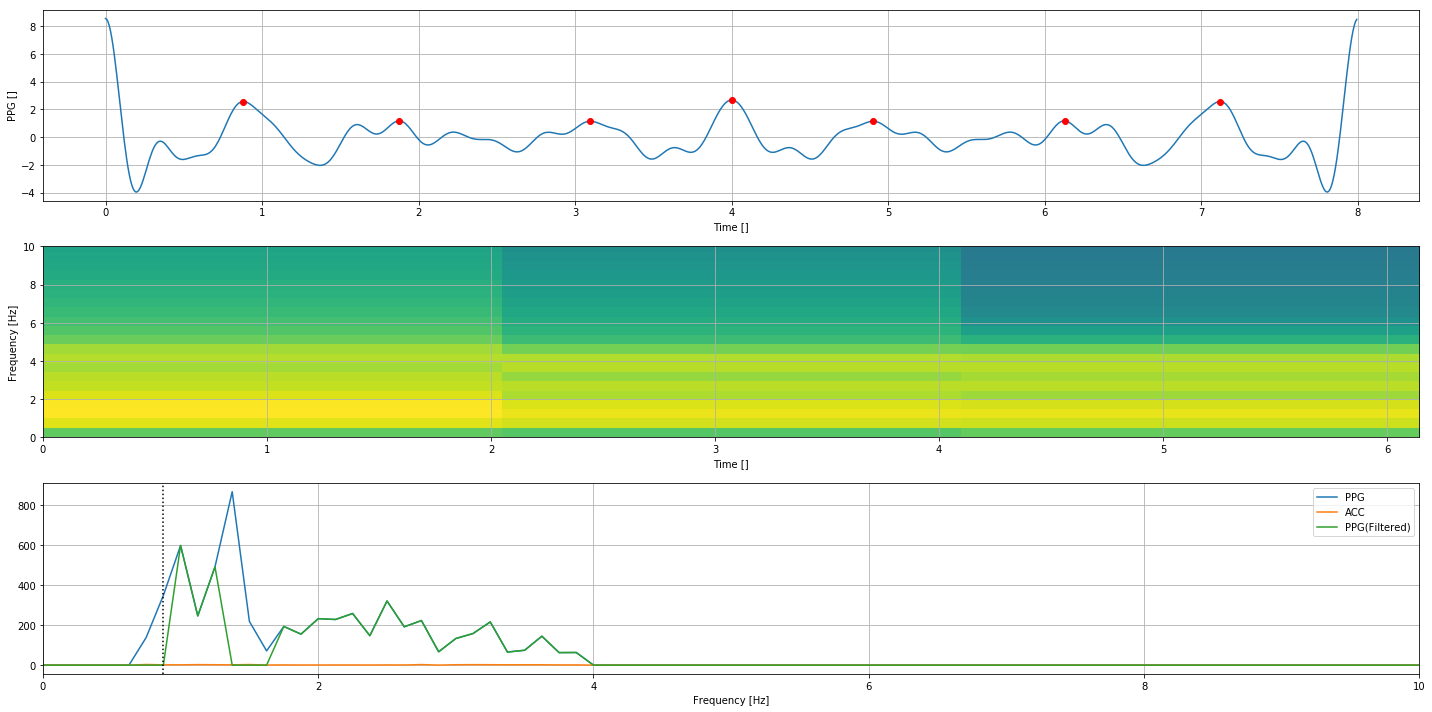

ground truth:82.8729, estimated:52.5
MAE:5.434934246575343


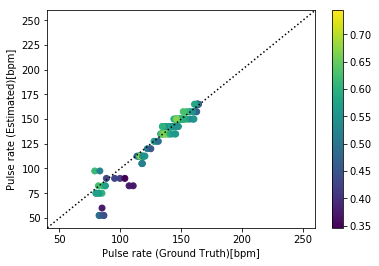

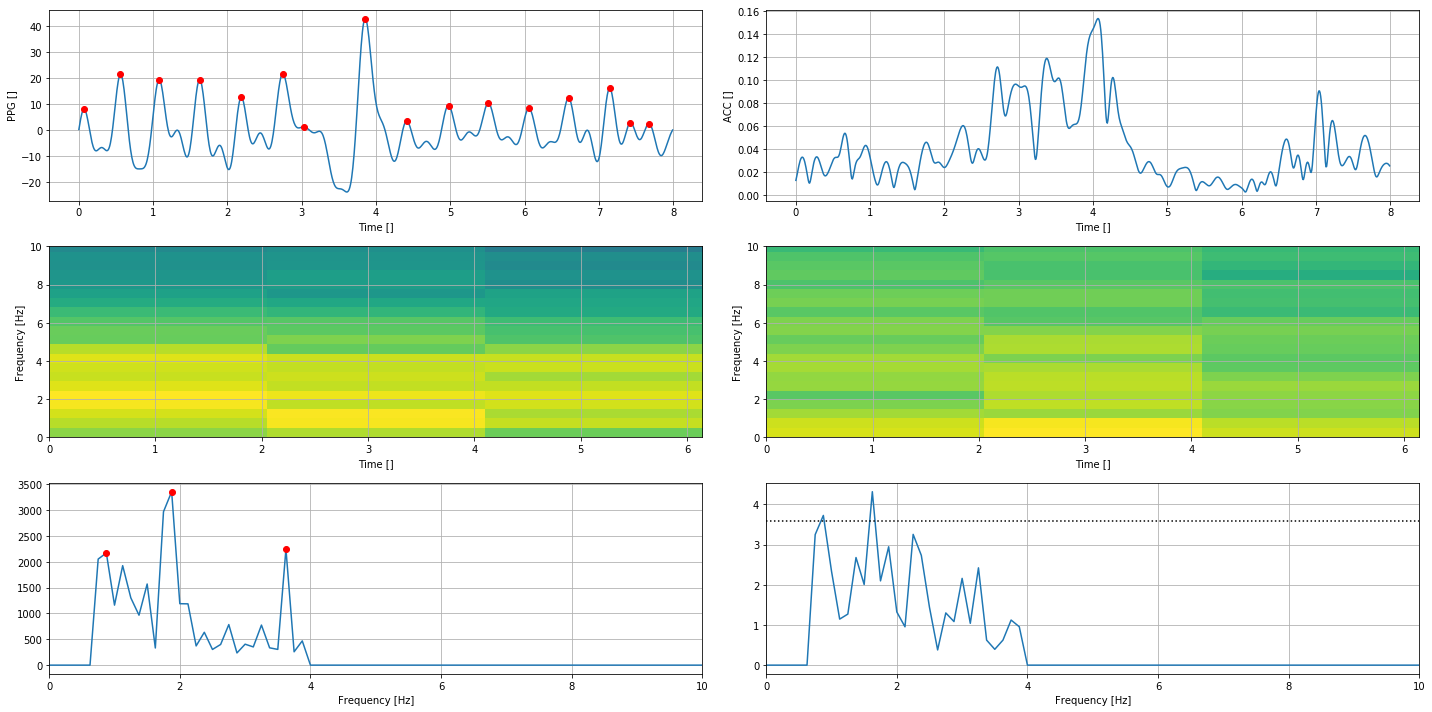

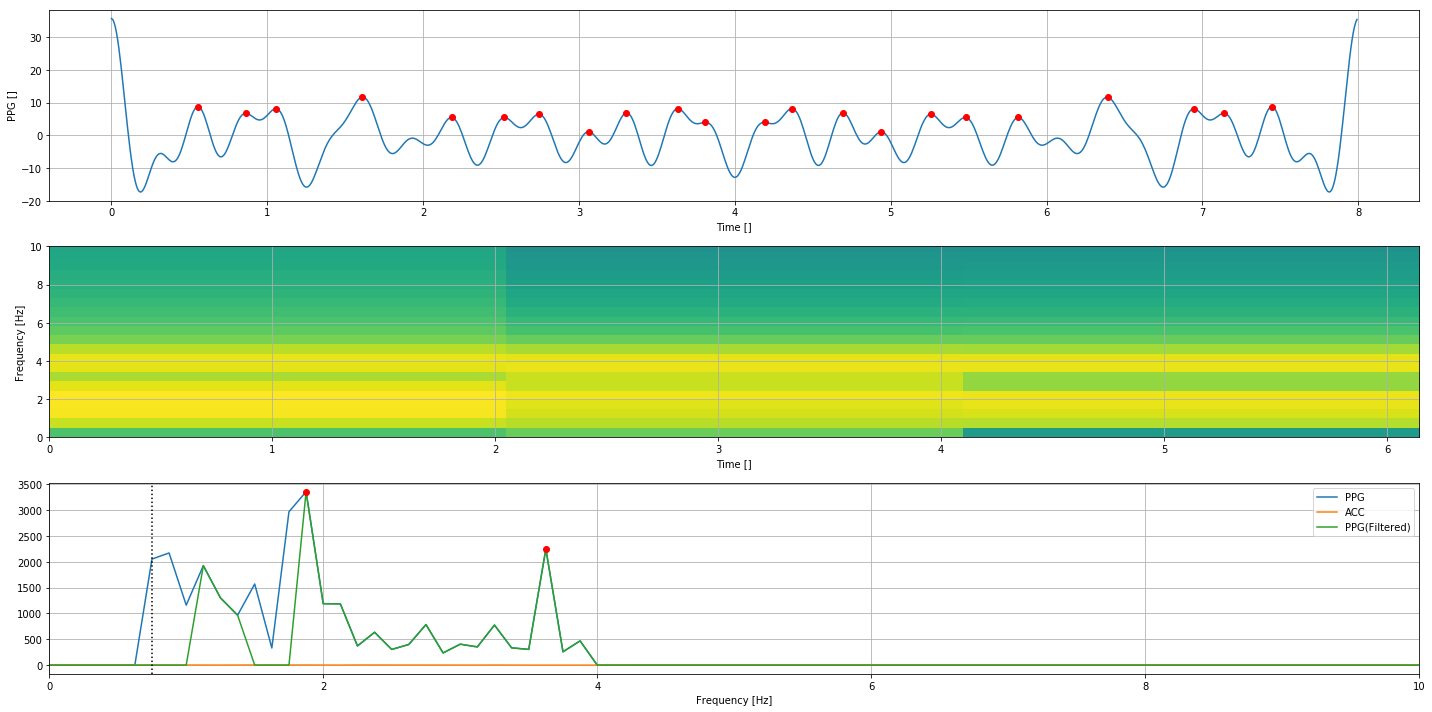

ground truth:109.7179, estimated:45.0
MAE:12.808302739726027


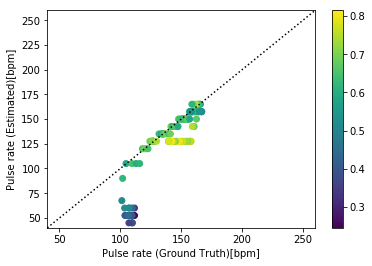

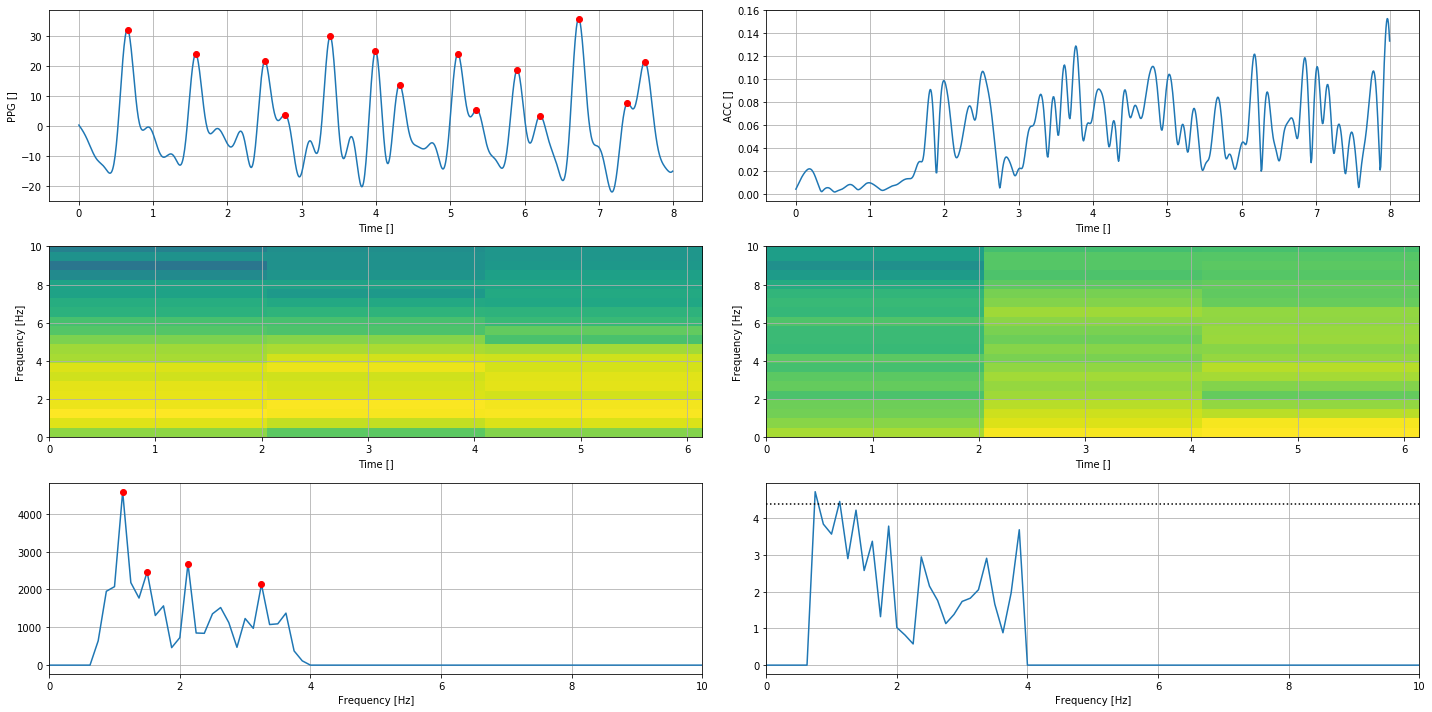

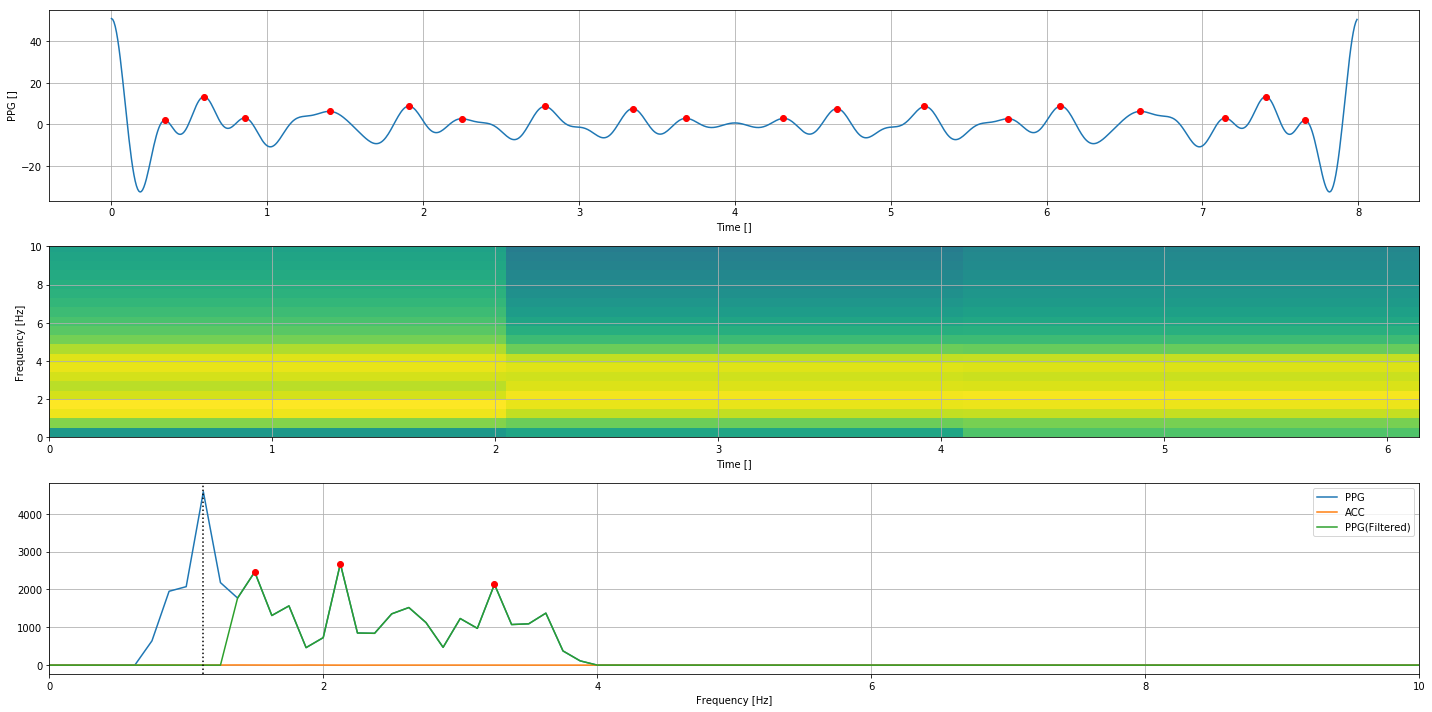

ground truth:68.7285, estimated:67.5
MAE:54.58958333333333


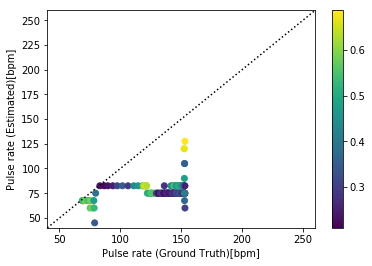

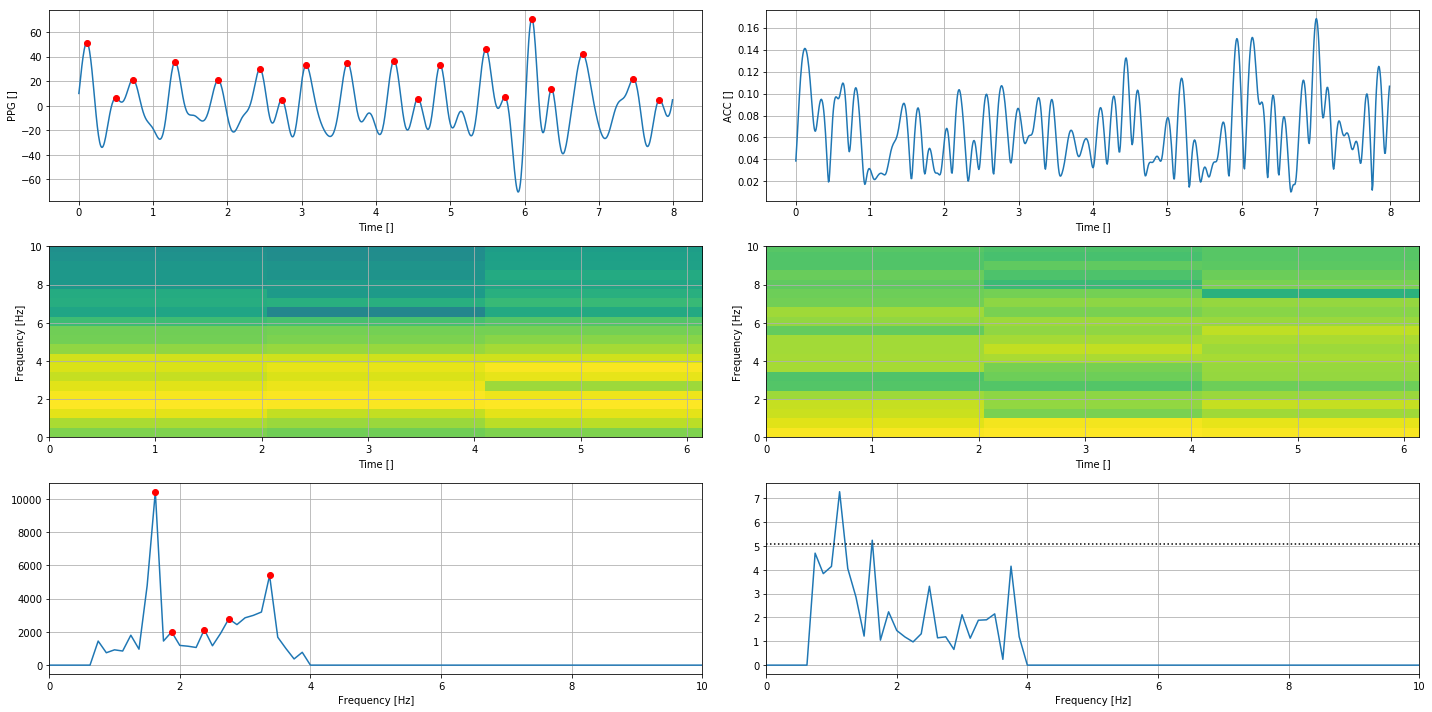

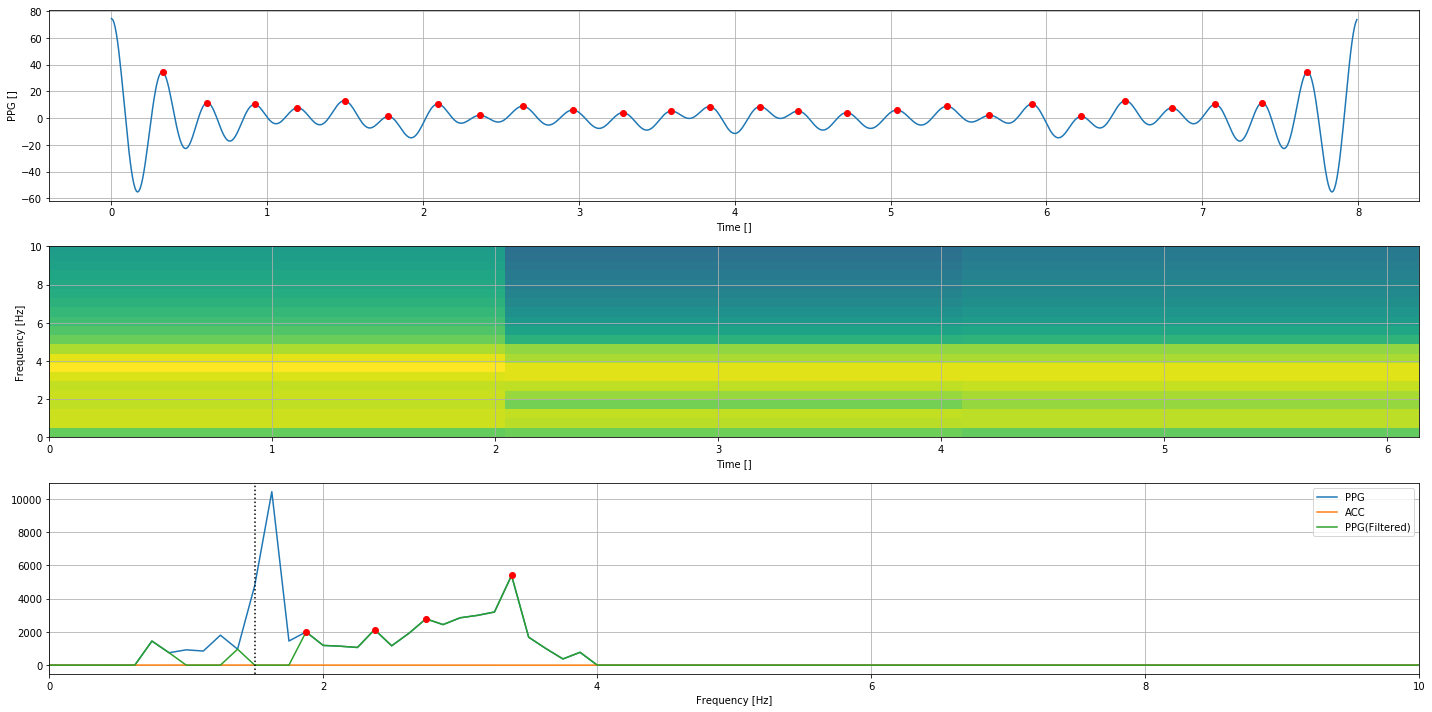

ground truth:97.7198697068404, estimated:90.0
MAE:4.5173760103635345


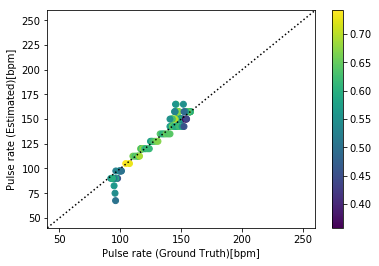

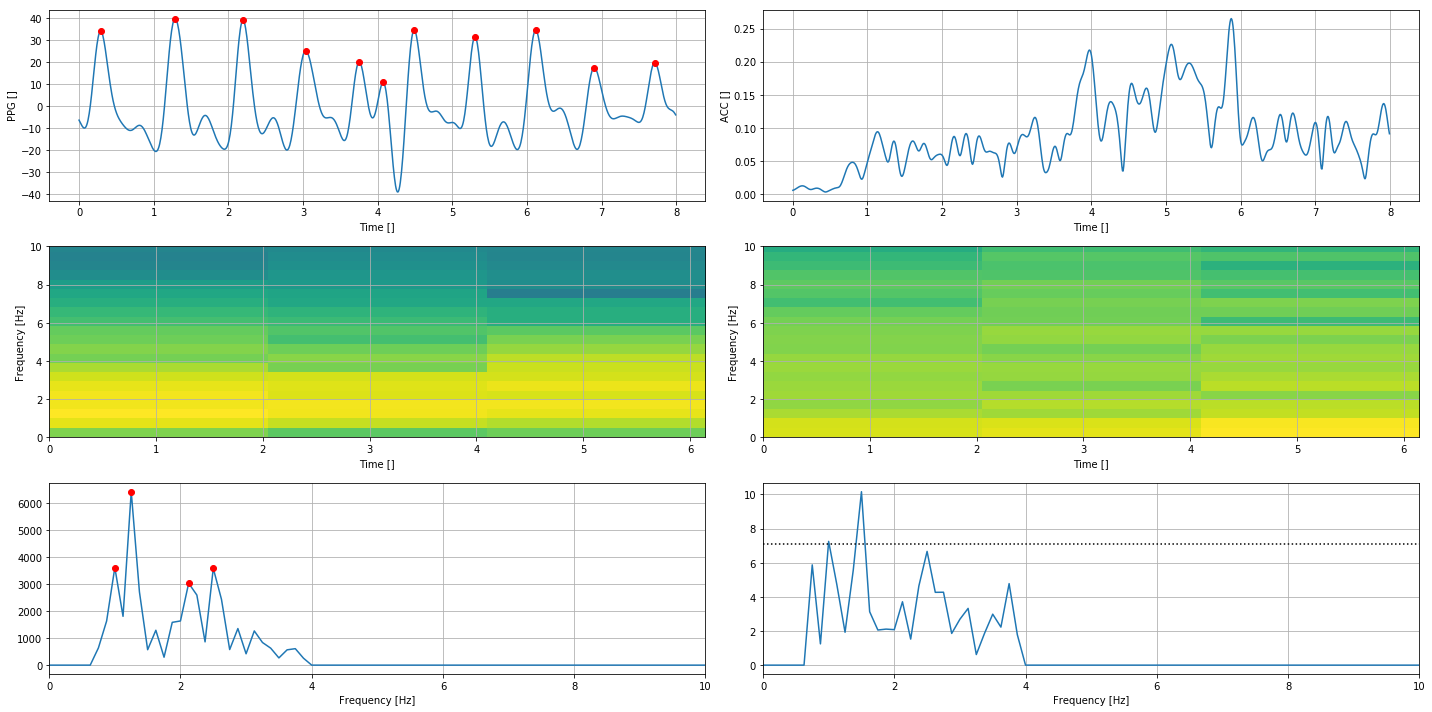

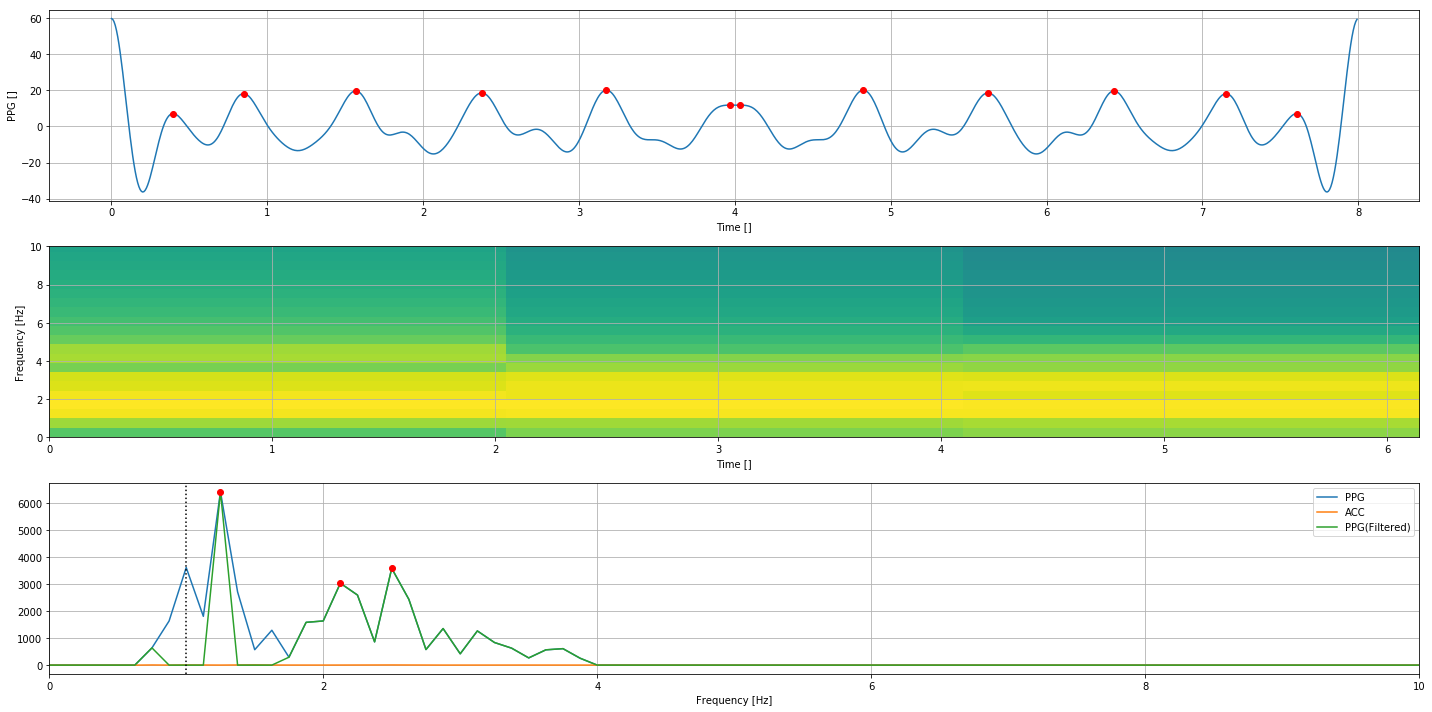

ground truth:74.5342, estimated:60.0
MAE:14.907318125


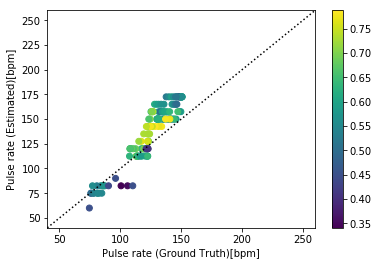

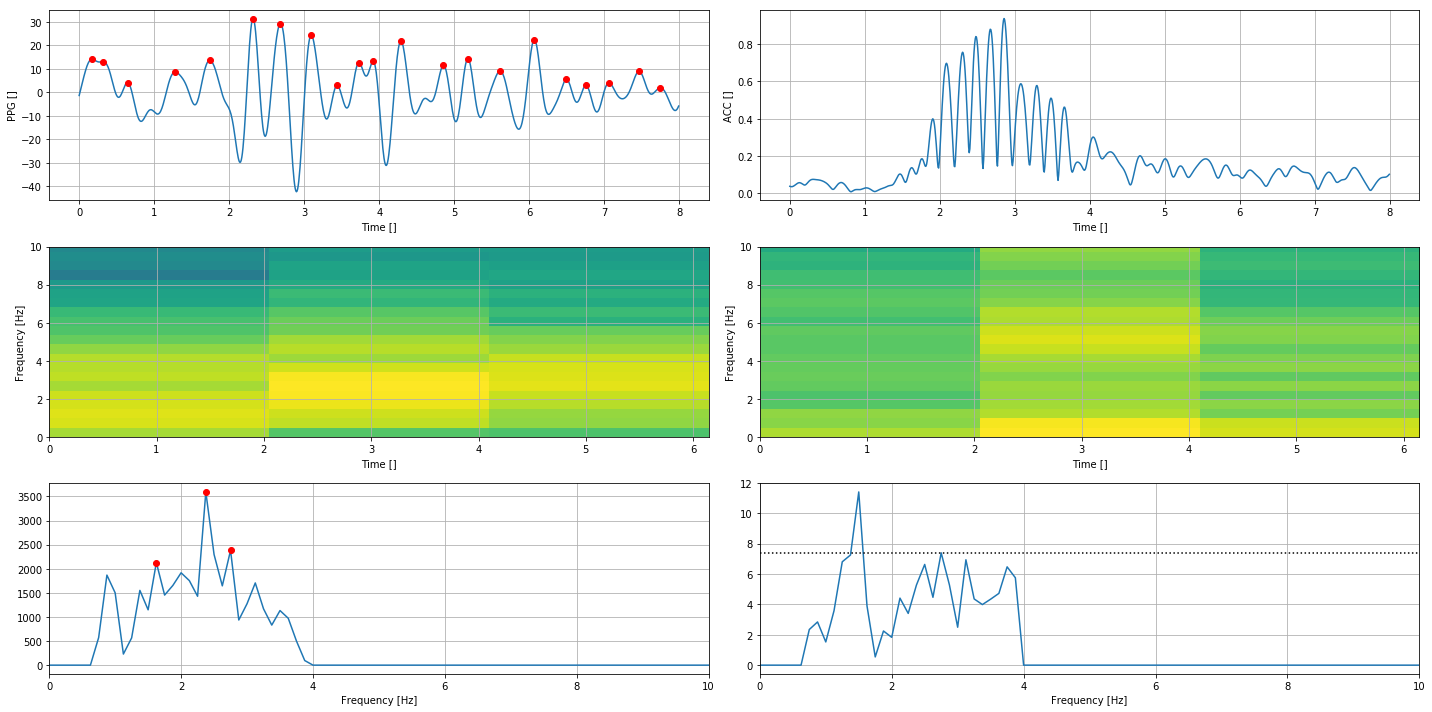

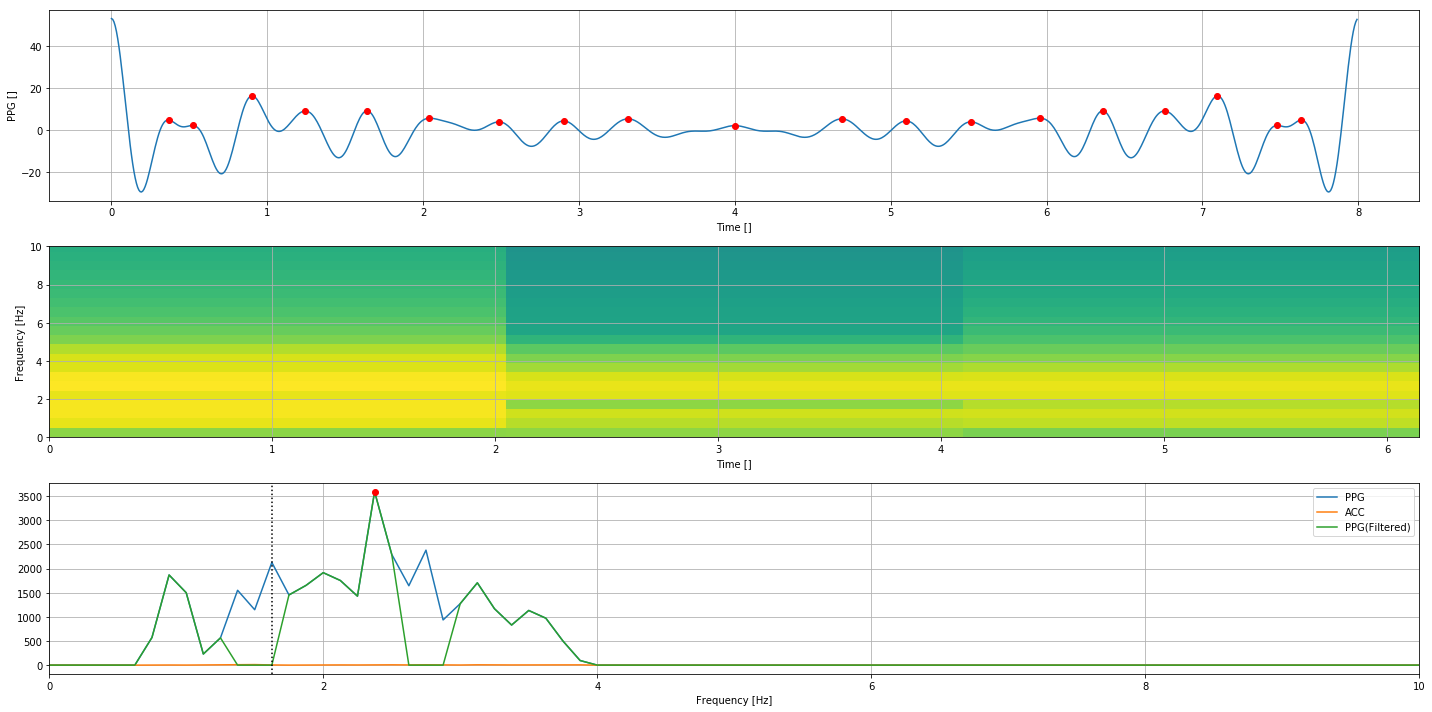

ground truth:123.4907, estimated:97.5
MAE:9.3751966442953


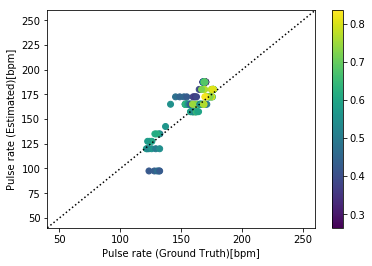

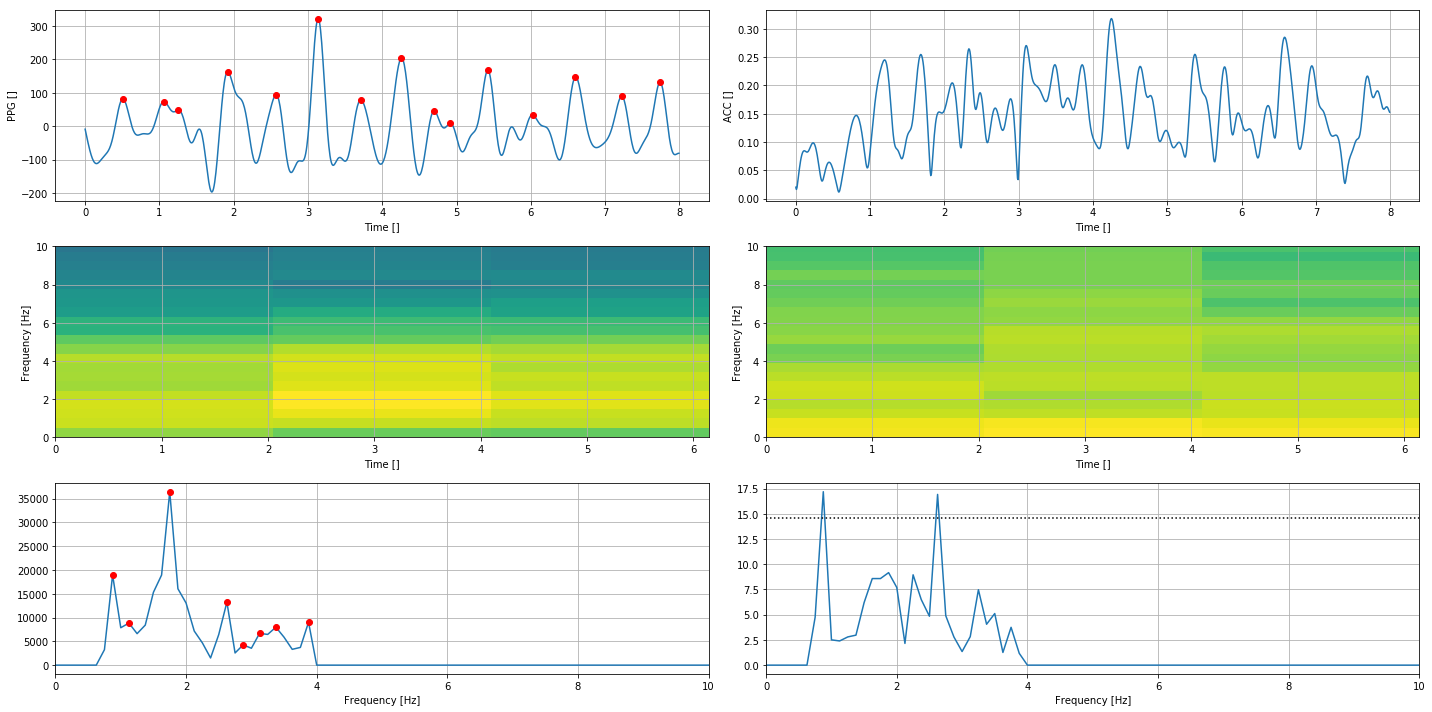

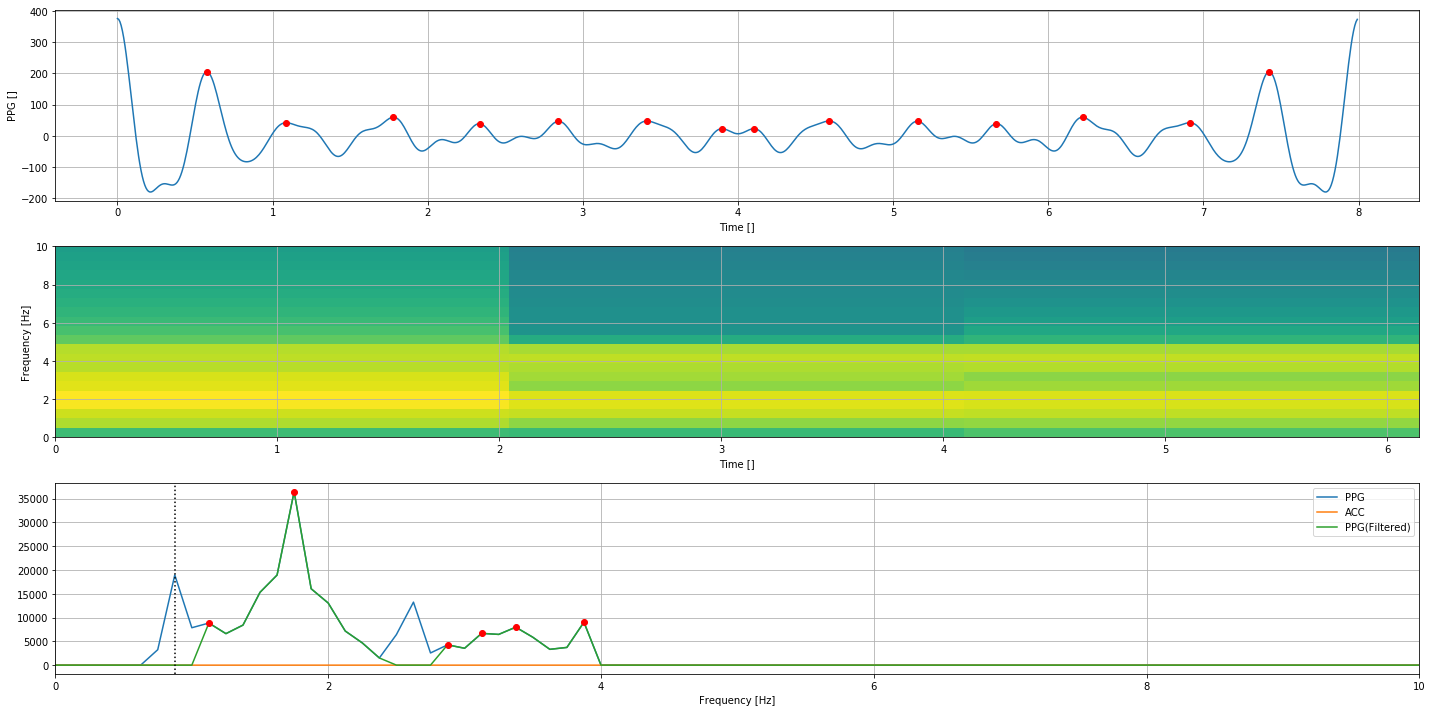

ground truth:115.3846, estimated:52.5
MAE:5.77138111888112


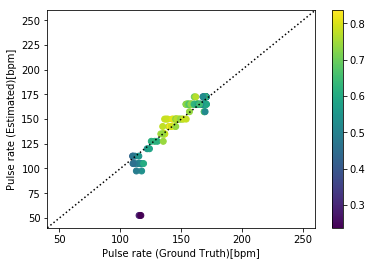

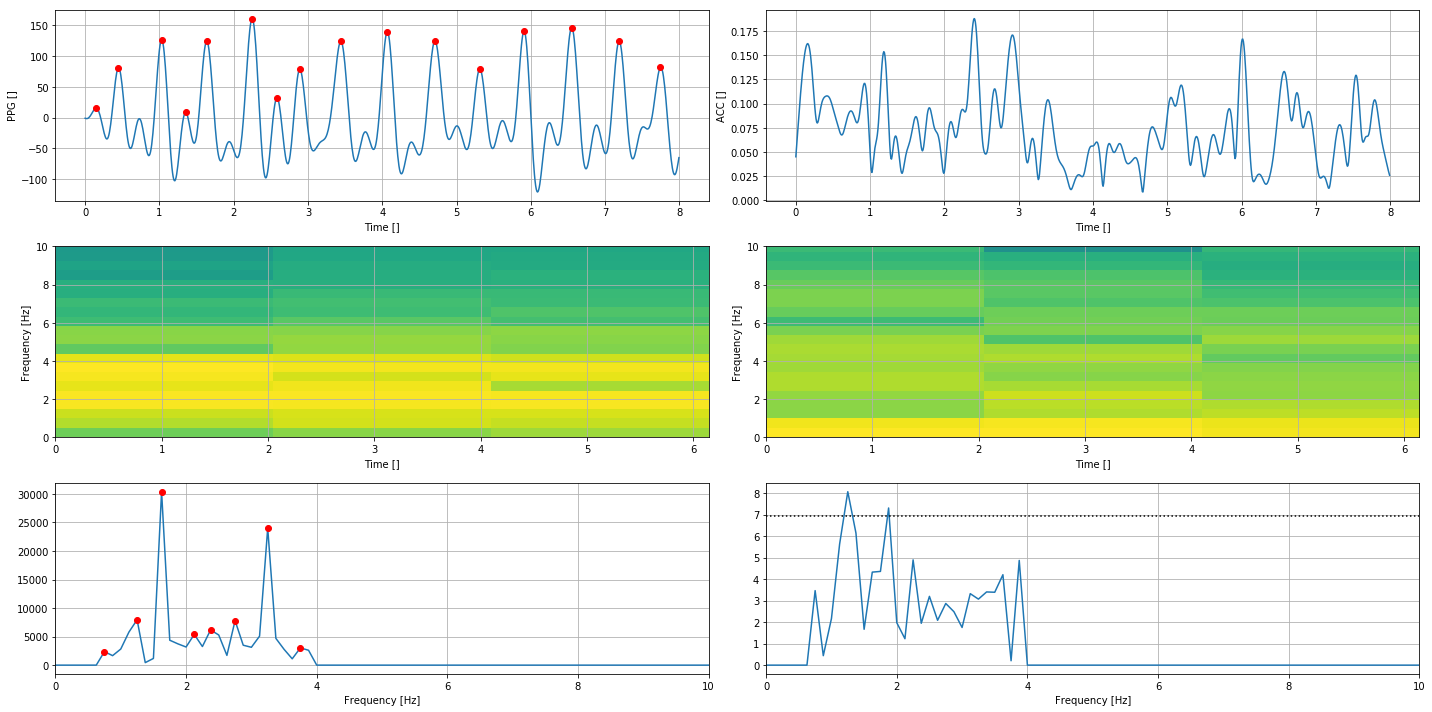

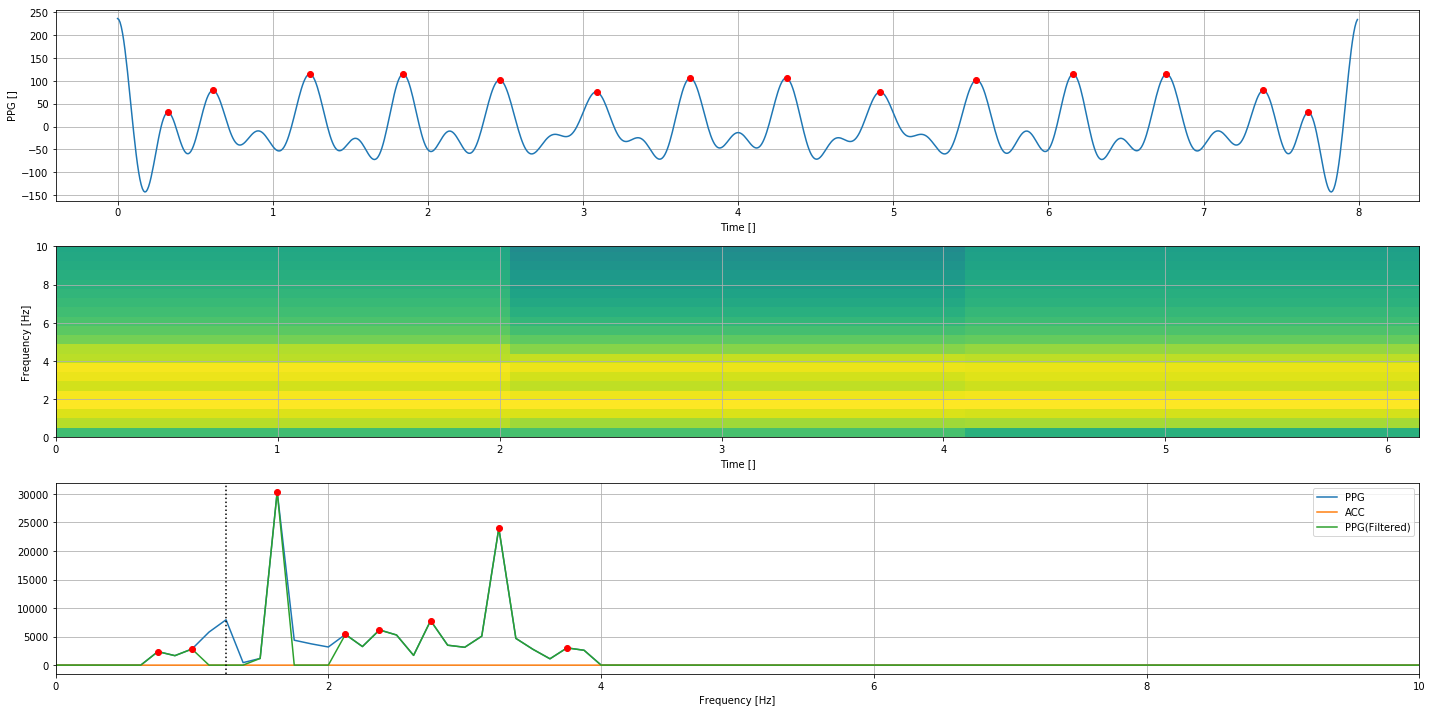

ground truth:97.9325, estimated:75.0
MAE:7.116990410958904


11.208190887941338

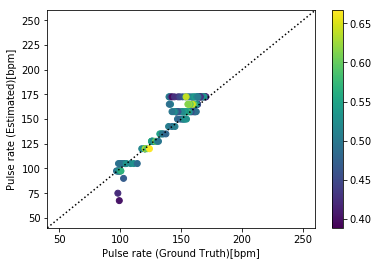

In [4]:
Evaluate()

In [5]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

from matplotlib import pyplot as plt

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Set parameters
    fs = 125
    pass_band = (40/60, 240/60)
    cutoff_freq = 12
    verbose = False
    window_size = 8*fs # Ground truth BPM provided in 8 second windows
    window_shift = 2*fs # Successive ground truth windows overlap by 2 seconds
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
        
    # Load ground truth pulse rate 
    # It was measurec each 8 second
    ground_truth = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1) 
    
    # Compute pulse rate estimates and estimation confidence.
    #########################################
    # ------------ Pre Process ------------ #
    #########################################
    # Bandpass filter
    ppg_filtered = BandpassFilter(ppg, pass_band, fs)
    accx_filtered = BandpassFilter(accx, pass_band, fs)
    accy_filtered = BandpassFilter(accy, pass_band, fs)
    accz_filtered = BandpassFilter(accz, pass_band, fs)
    
    # The accelerometer channels are aggregated into a magnitude signal.
    acc_filtered = np.sqrt(accx_filtered ** 2 + accy_filtered ** 2 + accz_filtered ** 2)
    
    ##########################################
    # ------------ Main Process ------------ #
    ##########################################
    # Estimate pulse rate with confidence
    estimated_pulse_rates = []
    confidences = []
    estimated_pulse_rate_previous = 1
    
    for i in range(len(ground_truth)):
        estimated_pulse_rate, confidence = EstimatePulseRate(ppg_filtered[window_shift*i : window_shift*i+window_size], 
                                                             acc_filtered[window_shift*i : window_shift*i+window_size], 
                                                             fs, pass_band, estimated_pulse_rate_previous)
        estimated_pulse_rates.append(estimated_pulse_rate)
        confidences.append(confidence)
        
        estimated_pulse_rate_previous = estimated_pulse_rate
       
    ################################################
    # ------------ Evaluation Process ------------ #
    ################################################
    # errors = np.abs(np.subtract(estimated_pulse_rates, ground_truth))
    errors = np.abs(np.subtract(np.convolve(np.array(estimated_pulse_rates), np.ones(5)/5.0, mode='same'), ground_truth))
    mae = np.mean(errors)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.array(errors), np.array(confidences)
    return errors, confidence

def EstimatePulseRate(ppg, acc, fs, pass_band, estimated_pulse_rate_previous, verbose=False):
    """
    Estimate Pulse rate with confidence using ppg and accelerometer data.

    Args:
        ppg: (np.array) a PPG signal
        acc: (np.array) an accelerometer signal
        fs: (number) a sampling rate of ppg/acc
        pass_band: (tuple) a bass band of band-pass filter for ppg/acc
        estimated_pulse_rate_previous: (number) previous estimated value of pulse rate
        verbose: (bool) Displays intermediate calculation results and diagrams
        
    Returns:
        estimated_pulse_rate: (number) estimated value of pulse rate
        confidence: (number) confidence value of the estimated pulse rate
        
    """ 
       
    # Do FFT
    freqs_ppg, fft_mag_ppg = DoFFT(ppg, fs)
    freqs_acc, fft_mag_acc = DoFFT(acc, fs)
    
    # Apply filter
    fft_mag_ppg[freqs_ppg <= pass_band[0]] = 0.0
    fft_mag_ppg[freqs_ppg >= pass_band[1]] = 0.0
    fft_mag_acc[freqs_acc <= pass_band[0]] = 0.0
    fft_mag_acc[freqs_acc >= pass_band[1]] = 0.0
    
    # Calculate maximum frequency of ppg and acc
    maximum_freq_ppg = freqs_ppg[np.argmax(fft_mag_ppg, axis=0)]  
    maximum_freq_acc = freqs_acc[np.argmax(fft_mag_acc, axis=0)]
    
    # Exclude the peak frequency band of acc from the frequency band of ppg
    fft_mag_ppg_new = fft_mag_ppg.copy()
    fft_mag_th = np.percentile(fft_mag_acc[(freqs_acc >= (40/60)) & (freqs_acc <= (240/60))], 95) # 95 percentile
    # fft_mag_ppg_new[fft_mag_acc>fft_mag_th] = 0.0
    fft_mag_ppg_new[np.convolve(fft_mag_acc>fft_mag_th, np.ones(3), 'same').astype(np.bool)] = 0.0
    
    # Inverse FFT
    ppg_new = DoInverseFFT(fft_mag_ppg_new)
    pks_ppg_new = DetectPeaks(ppg_new, height=1, distance=None)
    
    # Detect peaks of ppg
    pks_ppg = DetectPeaks(ppg, height=1, distance=None)
    pks_fft_mag_ppg = DetectPeaks(fft_mag_ppg, height=2000)
    pks_fft_mag_ppg_new = DetectPeaks(fft_mag_ppg_new, height=2000)

    # If the maximum frequency of ppg and the maximum frequency of acc are the same, 
    # calculate the pulse rate by excluding the maximum frequency of acc from ppg
    if(maximum_freq_ppg == maximum_freq_acc):  
        
        # Extract 5 maximum values, excluding the maximum value of acc
        est_range = np.argsort(fft_mag_ppg[fft_mag_ppg!=maximum_freq_acc], axis=0)[-5:]
        
        # Select the closest value from the previous estimate
        freq_pulse_rate = freqs_ppg[est_range[np.argmin(np.abs(freqs_ppg[est_range] - (estimated_pulse_rate_previous/60)))]]
        
        # Estimate pulse rate with confidence
        estimated_pulse_rate = freq_pulse_rate * 60
        confidence = CalculateConfidence(freq_pulse_rate, freqs_ppg, fft_mag_ppg)
    else:
        
        # Extract 5 maximum values
        est_range = np.argsort(fft_mag_ppg, axis=0)[-5:]
        
        # Select the closest value from the previous estimate
        freq_pulse_rate = freqs_ppg[est_range[np.argmin(np.abs(freqs_ppg[est_range] - (estimated_pulse_rate_previous/60)))]]
        
        # Estimate pulse rate with confidence
        estimated_pulse_rate = freq_pulse_rate * 60
        confidence = CalculateConfidence(freq_pulse_rate, freqs_ppg, fft_mag_ppg)
    
    return estimated_pulse_rate, confidence

def BandpassFilter(signal, pass_band, fs):
    """
    Applies bandpass filter.
    
    Args:
        signal: (np.array) an input signal
        pass_band: (tuple) a pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) a sampling rate of <signal>
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def LowpassFilter(signal, cutoff_freq, fs):
    """
    Applies lowpass filter.
    
    Args:
        signal: (np.array) an input signal
        cutoff_freq: (number) a frequency to want to cut off
        fs: (number) a sampling rate of <signal>
        
    Returns:
        (np.array) a filtered signal
    """
    b, a = sp.signal.butter(3, cutoff_freq, btype='lowpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)
    
def DetectPeaks(signal, height=10, distance=35):
    """
    Detects peaks of the signal.
    
    Args:
        signal: (np.array) an input signal
        height: (number) a threshold of height of peak 
        distance: (number) a threshold of distance between peaks
    
    Returns: 
        signal: (np.array) am index of input signal's peaks
    
    """
    pks = sp.signal.find_peaks(signal, height, distance)[0]
    return pks
    
def DoFFT(signal_time_domain, fs):
    """
    Applies Fast Fourier Transform.
    
    Args:
        signal_time_domain: (np.array) an input time-domain signal
        fs: (number) a sampling rate of <signal>
    
    Returns: 
        freqs: (np.array) a FFT frequency of the input signal
        fft_mag: (np.array) a FFT amplitude spectrum of the input signal
    
    """
    freqs = np.fft.rfftfreq(len(signal_time_domain), 1/fs)
    fft_mag = np.abs(np.fft.rfft(signal_time_domain))
    return freqs, fft_mag

def DoInverseFFT(signal_freq_domain):
    """
    Applies Inverse Fast Fourier Transform.
    
    Args:
        signal_freq_domain: (np.array) an input frequency-domain signal
    
    Returns: 
        (np.array) a time-domain signal
    
    """
    
    return np.fft.irfft(signal_freq_domain)

def CalculateConfidence(freq_estimated_pulse_rate, freqs_ppg, fft_mag_ppg):
    """
    Calculates a confidence value for the chosen frequency by computing the ratio of energy concentrated near that frequency compared to the full signal.
    
    Args:
        freq_estimated_pulse_rate: (number) a pulse rate estimated by the algorithm
        freqs_ppg: (np.array) a FFT frequency of ppg
        fft_mag_ppg: (np.array) a FFT amplitude spectrum of ppg
    
    Returns:
        confidence: (number) a confidence of pulse rate estimated by the algorithm
    
    """
    window = (freqs_ppg >= freq_estimated_pulse_rate - (40/60.0)) & (freqs_ppg <= freq_estimated_pulse_rate + (40/60.0))
    confidence = np.sum(fft_mag_ppg[window])/np.sum(fft_mag_ppg)
    
    return confidence

In [6]:
Evaluate()

11.208190887941338

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

- **Code Description** - The code provided is a Python implementation of a pulse rate estimation algorithm using PPG (photoplethysmogram) and accelerometer signals. The algorithm processes the PPG and accelerometer signals to estimate the pulse rate with confidence. It also computes the Mean Absolute Error (MAE) at 90% availability as an aggregate error metric.


- **Data Description** - The algorithm uses the Troika dataset, which consists of PPG and accelerometer signals collected from different individuals during various activities. The PPG signal measures blood volume changes in the skin, while the accelerometer signals capture motion-related information. Shortcomings of the dataset: The dataset may not cover all possible scenarios, such as extreme activities or challenging conditions. Additionally, it is essential to have corresponding reference heart rate data for the evaluation of the algorithm.
Data required for a more complete dataset: To build a more comprehensive dataset, it would be beneficial to include a broader range of activities, diverse age groups, and individuals with various health conditions.


- **Algorithhm Description** -The algorithm starts by applying a bandpass filter to the PPG and accelerometer signals to isolate the frequency range of interest (40-240 BPM). It then calculates the Fast Fourier Transform (FFT) for both signals to identify the dominant frequencies. If the maximum frequency of the PPG signal matches that of the accelerometer signal, the algorithm excludes the accelerometer peak frequency from the PPG peak frequencies. Otherwise, it uses all PPG peak frequencies. The algorithm selects the pulse rate estimate by choosing the PPG peak frequency that is closest to the previous estimated pulse rate. It calculates the confidence of the pulse rate estimate by computing the ratio of energy concentrated near the chosen frequency compared to the full signal.

    - Algorithm Outputs:
        The algorithm outputs the pulse rate estimates and their corresponding confidences for each segment of the input signal.

    - Caveats on Algorithm Outputs:
        The algorithm assumes that the maximum frequency of the PPG signal corresponds to the pulse rate. In some scenarios, motion artifacts or other interference might affect the PPG signal, leading to inaccurate pulse rate estimates. The algorithm uses a basic bandpass filter and peak detection method, which may not be sufficient for complex scenarios or noisy data.

    - Common Failure Modes:
        The algorithm may produce inaccurate pulse rate estimates if the PPG signal is significantly corrupted by motion artifacts or other noise sources. If the PPG and accelerometer signals are not well-synchronized or have different sampling rates, it can lead to incorrect pulse rate estimates. The algorithm's confidence estimation may not be accurate if the dominant frequency of the PPG signal is not a reliable indicator of the pulse rate due to interference or poor signal quality.



- **Algorithm Performance** - Performance was evaluated using the Mean Absolute Error (MAE) at 90% availability. It measures the accuracy of the pulse rate estimates compared to the corresponding reference heart rates. The algorithm's performance was computed using the provided Troika dataset. The performance metrics are relevant to users who are interested in obtaining pulse rate estimates from PPG and accelerometer signals. The algorithm's generalizability might be limited to similar datasets with similar characteristics to the Troika dataset. It may not perform as well on data from different sources or different activity scenarios. To improve generalizability, the algorithm should be validated on diverse datasets.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 